<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/11_20_XGBoost_FINAL_IDC_Prediction_heesuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

**XGBoost:** an optimized version of Gradient Boosting / much more evolved version of Random Forest in terms of speed and accuracy

#Predicting IDC with Breast Histopathology Images using CNN



In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *  
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from keras.layers import ReLU, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import ReLU, LeakyReLU
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn import metrics
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('INFO')


import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [2]:
# y_train

## Install Optuna and Version Check

In [3]:
# !pip install lightgbm
# !pip install --quiet optuna
# import optuna
# optuna.__version__

In [4]:
# !pip install -q -U keras-tuner
# import keras_tuner as kt

# !pip install xgboost
import xgboost as xgb

## Enabling and testing the GPU

In [5]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## Enabling and testing the TPU

## Observe TensorFlow speedup on GPU relative to CPU

In [6]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

In [7]:
def get_paths(directory):
  all_path = []
  idc_image_path = []
  idc_image_label = []

  for dir, subdir, files in os.walk(directory):
    path = dir + "/"
    all_path.append(path)

  for i in range(len(all_path)):
    for file in os.listdir(all_path[i]):
      test = file
      path = all_path[i] + test
      if path.lower().endswith('.png'):
        idc_image_path.append(path)

  for i in range(len(idc_image_path)):
    split_test = idc_image_path[i]
    split_path = split_test.split("/")
    directory_name = split_path[7]
    idc_image_label.append('class_' + split_path[8])
  return idc_image_path, idc_image_label, directory_name

In [8]:
train_paths, train_labels, train_dir = get_paths(train_image_directory)
val_paths, val_labels, val_dir = get_paths(val_image_directory)
test_paths, test_labels, test_dir = get_paths(test_image_directory)

In [9]:
print(train_labels[:5])
print(train_labels[-5:])

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))
print(len(val_paths), len(val_labels))

['class_0', 'class_0', 'class_0', 'class_0', 'class_0']
['class_1', 'class_1', 'class_1', 'class_1', 'class_1']
800 800
200 200
200 200


In [10]:
print(train_paths[:2])
print(train_labels[:10])
print(train_dir)

['/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12880_idx5_x451_y701_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9345_idx5_x2001_y2001_class0.png']
['class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0']
Train


In [11]:
def create_dataframes(idc_image_path, idc_image_label, directory_name):
  same_name = directory_name.lower() + '_'
  #creating the dataframes that we will be passing to our generators
  idc_data_cleaned = {'path': idc_image_path,
            'label': idc_image_label}
  idc_df = pd.DataFrame(idc_data_cleaned)
  idc_df['label_int'] = idc_df['label'].str.split("_", expand=True)[1]    # Added a new column 'label_int'
  df = idc_df.sample(frac = 1)
  print(df)
  csv_path = directory_path
  csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
  csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
  return csv_file_path

In [12]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
print('type(train_dataframe): ',type(train_dataframe))
train_dataframe

                                                  path    label label_int
426  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
130  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
236  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
143  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
436  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
..                                                 ...      ...       ...
561  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
472  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
289  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
564  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
292  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0

[800 rows x 3 columns]
type(train_dataframe):  <class 'str'>


'/content/gdrive/MyDrive/Kaggle/CNN_IDC/train_idc_dataframe.csv'

In [13]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
train_generator = pd.read_csv(train_dataframe)

test_dataframe = create_dataframes(test_paths, test_labels, test_dir)
test_generator = pd.read_csv(test_dataframe)

val_dataframe = create_dataframes(val_paths, val_labels, val_dir)
val_generator = pd.read_csv(val_dataframe)

                                                  path    label label_int
378  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
325  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
317  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
622  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
470  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
..                                                 ...      ...       ...
171  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
52   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
771  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1
67   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0         0
783  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1         1

[800 rows x 3 columns]
                                                  path    label label_int
97   /content/

In [14]:
from tqdm import tqdm # import tqdm

# Apply gray scale to all images, flatten and store array / shape in new columns
def get_img_arrays(df,):
    # read each image array from corresponding path as grayscale and flatten the image array
    df['img_array'] = df.progress_apply(lambda x : io.imread(x['path'],as_gray=True).flatten(),axis=1) # make sure to specify axis = 1
    # get the shape of each image array and store it in the dataframe
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
    return df


In [15]:
from tqdm import tqdm # import tqdm
tqdm.pandas() # initialize tqdm for pandas

# # tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar

train_generator = get_img_arrays(df = train_generator)
val_generator = get_img_arrays(df = val_generator)
test_generator = get_img_arrays(df = test_generator)

100%|██████████| 200/200 [00:00<00:00, 37858.15it/s]


In [16]:
# print(train_generator.array_shape.value_counts())
# print(val_generator.array_shape.value_counts())
# print(test_generator.array_shape.value_counts())

In [17]:
# drop these images as they add unnecessary noise to our model
train_weird_imgs = train_generator[train_generator['array_shape'] != 2500]
val_weird_imgs = val_generator[val_generator['array_shape'] != 2500]
test_weird_imgs = test_generator[test_generator['array_shape'] != 2500]


weird_imgs = train_weird_imgs.append(val_weird_imgs)
weird_imgs = weird_imgs.append(test_weird_imgs)
weird_imgs['dataset'] = weird_imgs['path'].str.split('/', expand=True)[7]
weird_imgs.reset_index(drop=True)

train_generator.drop(train_weird_imgs.index,inplace=True)
val_generator.drop(val_weird_imgs.index,inplace=True)
test_generator.drop(test_weird_imgs.index,inplace=True)

# print(len(weird_imgs))
# print(len(train_generator))
# print(len(val_generator))
# print(len(test_generator))
# print(train_generator.columns)
# val_generator.reset_index(drop=True)

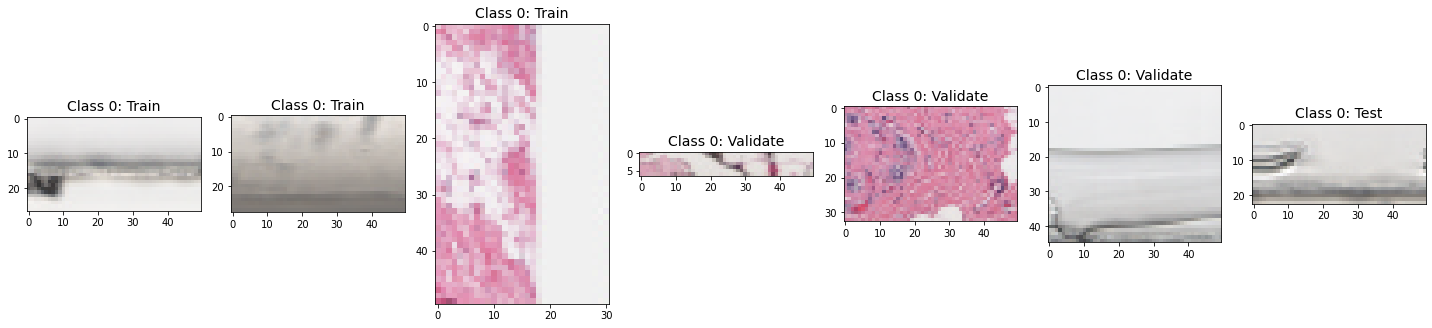

In [18]:
import cv2 as cv
import skimage.io as io

def display_images(subclass):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
  for idx, ax in enumerate(axes.flat):
    image_wo_path = os.path.basename(subclass.path[idx])
    # print(image_wo_path)
    subtitle = 'Class ' + image_wo_path.rsplit('.')[0][-1] + ': ' + subclass.dataset[idx]
    img = io.imread(subclass.path[idx])
    ax.imshow(img)
    # ax.axis('off')
    ax.set_title(subtitle, size=14)   
  fig.tight_layout() 
  plt.show() 

print()
display_images(weird_imgs.reset_index(drop=True))

In [19]:
train_generator

,Unnamed: 0,path,label,label_int,img_array,array_shape
0,378,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_0,0,"[0.6585917647058823, 0.6490443137254902, 0.617...",2500
1,325,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_0,0,"[0.6615933333333333, 0.7515749019607842, 0.821...",2500
2,317,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_0,0,"[0.929098431372549, 0.8974054901960784, 0.8850...",2500
3,622,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_1,1,"[0.6526560784313726, 0.6681733333333334, 0.635...",2500
4,470,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_1,1,"[0.3537521568627451, 0.4285525490196079, 0.360...",2500
...,...,...,...,...,...,...
795,171,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_0,0,"[0.9417192156862746, 0.8295694117647059, 0.855...",2500
796,52,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_0,0,"[0.4892843137254902, 0.4694086274509804, 0.552...",2500
797,771,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_1,1,"[0.5298611764705883, 0.39288823529411765, 0.43...",2500
798,67,/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...,class_0,0,"[0.5928521568627452, 0.48497490196078435, 0.56...",2500


In [26]:
X_train_image_pixels = [io.imread(img) for img in train_generator['path']]
X_val_image_pixels = [io.imread(img) for img in val_generator['path']]
X_test_image_pixels = [io.imread(img) for img in test_generator['path']]

print(len(X_train_image_pixels))
X_train_image_pixels

797


[array([[[232, 148, 177],
         [232, 145, 173],
         [230, 135, 165],
         ...,
         [225, 120, 153],
         [226, 145, 172],
         [226, 138, 166]],
 
        [[231, 140, 169],
         [230, 146, 172],
         [231, 130, 160],
         ...,
         [232, 166, 188],
         [226, 142, 169],
         [232, 144, 170]],
 
        [[233, 143, 169],
         [231, 136, 168],
         [226, 126, 151],
         ...,
         [225, 130, 156],
         [232, 155, 181],
         [231, 141, 169]],
 
        ...,
 
        [[229, 142, 169],
         [232, 150, 181],
         [226, 139, 164],
         ...,
         [233, 151, 179],
         [234, 149, 174],
         [234, 145, 173]],
 
        [[232, 149, 177],
         [230, 143, 168],
         [228, 139, 170],
         ...,
         [231, 142, 171],
         [232, 148, 176],
         [235, 141, 170]],
 
        [[232, 154, 180],
         [228, 133, 163],
         [230, 146, 172],
         ...,
         [232, 148, 175],
  

In [23]:
# y = train_generator['label_int'].values
# print(y)

In [32]:
import lightgbm as lightgbm
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import xgboost as xgb
import time

def build_xgboost(X_train_image_pixels, X_test_image_pixels):
  start_time = time.time()
  RESHAPED = 7500

  X_train_image_pixels = np.expand_dims(X_train_image_pixels, axis=0)    # expand from 2D to 3D
  X_test_image_pixels = np.expand_dims(X_test_image_pixels, axis=0)

  # X_train_image_pixels is 797 rows of 50x50x3 values => reshape in 797 x 7500
  X_train_image_pixels = np.array(X_train_image_pixels).reshape(797, RESHAPED)
  X_test_image_pixels = np.array(X_test_image_pixels).reshape(199, RESHAPED)
  # print(X_train_image_pixels.shape)

  X_train_image_pixels = X_train_image_pixels.astype('float32')
  X_test_image_pixels = X_test_image_pixels.astype('float32')

  y_train_image_pixels = np.reshape(train_generator['label_int'].values, (-1,1))
  y_test_image_pixels = np.reshape(test_generator['label_int'].values, (-1,1))
  # print(y_train_image_pixels.shape)

  y_train_image_pixels = y_train_image_pixels.flatten()
  y_test_image_pixels = y_test_image_pixels.flatten()
  # print(y_train_image_pixels.shape)

  # normailize the data
  X_train_image_pixels /= 255
  X_test_image_pixels /= 255

  print(X_train_image_pixels.shape[0], 'train samples')
  print(X_test_image_pixels.shape[0], 'test samples')
  # y_train_image_pixels

  # fit XGboost model to the data
  model = xgb.XGBClassifier(gamma=0.5, learning_rate=0.001, max_delta_step=0.1,
                            max_depth=6, min_child_weight=0.2, n_estimators=10,
                            nthread=4, objective='binary:logistic', reg_alpha=0.5,           # "multi:softmax" minimum number of classes should be 3
                            reg_lambda=0.8, scale_pos_weight=1, silent=False,
                            subsample=0.8)

  cv_results = cross_val_score(model, X_train_image_pixels, y_train_image_pixels,
                              cv=2, scoring='accuracy', n_jobs=-1, verbose=1)

  model.fit(X_train_image_pixels, y_train_image_pixels, verbose=True)

  print();print('cv_results:\n', cv_results)
  print();print('model:\n', model)

  # make predictions
  y_true = y_test_image_pixels
  y_pred = model.predict(X_test_image_pixels)
  print('y_true: ', y_true[:5])
  print('y_pred: ', y_pred[:5])

  # summarize the fit of the model
  print();print(metrics.classification_report(y_true, y_pred))
  print();print(metrics.confusion_matrix(y_true, y_pred))

  print();print('Execution time %s seconds: ' % (time.time() - start_time))

build_xgboost(X_train_image_pixels, X_test_image_pixels)

797 train samples
199 test samples


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s finished



cv_results:
 [0.79448622 0.78894472]

model:
 XGBClassifier(gamma=0.5, learning_rate=0.001, max_delta_step=0.1, max_depth=6,
              min_child_weight=0.2, n_estimators=10, nthread=4, reg_alpha=0.5,
              reg_lambda=0.8, silent=False, subsample=0.8)
y_true:  [0 0 1 0 1]
y_pred:  [0 0 0 0 0]

              precision    recall  f1-score   support

           0       0.76      0.77      0.76        99
           1       0.77      0.76      0.76       100

    accuracy                           0.76       199
   macro avg       0.76      0.76      0.76       199
weighted avg       0.76      0.76      0.76       199


[[76 23]
 [24 76]]

Execution time 15.182397365570068 seconds: 
